In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import csv
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta, date
import requests
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels

from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.utils import resample


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
#### read in the flattened dataframes with the labels
MSFT_df = pd.read_csv("/Users/fahad/project_repo/data/external/MSFT_flat.csv", index_col=0)
AAPL_df = pd.read_csv("/Users/fahad/project_repo/data/external/AAPL_flat.csv",index_col=0)
AMZN_df = pd.read_csv("/Users/fahad/project_repo/data/external/AMZN_flat.csv",index_col=0)

In [3]:

#vertically stack the MSFT and AAPL dataframes on top of eachother
df = pd.concat([MSFT_df, AAPL_df], axis=0)
#vertically stack the MSFT&AAPL df and the AMZN dataframe ontop of eachother
df = pd.concat([df,AMZN_df],axis = 0)
#set index to date
#df.set_index("Date")

df['Label'].value_counts()




1    448
0    320
Name: Label, dtype: int64

# Upsample under represented class

In [4]:
# Separate majority and minority classes
df_majority = df[df.Label==1]
df_minority = df[df.Label==0]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=448,    # to match majority class
                                 random_state=123) # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])
#y is the labels for the test/train split
y = df_upsampled.Label

#drop the label so we can split data into training and test
df_upsampled = df_upsampled.drop(['Label'], axis =1)

df_upsampled.head(5)


,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
1998-03-31,0.429339,0.425285,0.432434,0.426907,0.020233,0.627285,0.373432,0.500535,0.519246,0.231693,...,0.710965,0.703805,0.005767,0.226505,0.019309,0.457683,0.712130,0.453455,0.0,0.0
1998-04-30,0.444974,0.443069,0.449092,0.441714,0.005799,0.403578,0.305363,0.475177,0.588950,0.276414,...,0.864060,0.844894,0.012340,0.954846,0.966738,0.509452,0.514381,0.640977,0.0,0.0
1998-06-30,0.430866,0.429412,0.436288,0.431822,0.007196,0.440966,0.357870,0.644377,0.636887,0.290104,...,0.468175,0.464470,0.011004,0.510333,0.361165,0.499703,0.595590,0.298256,0.0,0.0
1998-07-31,0.551484,0.558813,0.561785,0.560046,0.022155,0.358593,0.250476,0.596634,0.595164,0.371578,...,0.432807,0.430305,0.028320,0.486961,0.394788,0.617644,0.629785,0.248232,0.0,0.0
1998-09-30,0.568279,0.570527,0.558677,0.546756,0.025059,0.586977,0.305362,0.559590,0.666430,0.563441,...,0.633640,0.618059,0.013599,0.647949,0.373647,0.596837,0.595164,0.462133,0.0,0.0


In [5]:
#define the target variable as y 
X_train, X_test, y_train, y_test = train_test_split(df_upsampled, y, test_size=0.3)
#print (X_train.head(5))


In [6]:
def make_timeseries_classifier(sample_num,window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=16):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size,nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    return model

In [7]:

model_1 = make_timeseries_classifier(X_train.shape[0],X_train.shape[1],3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(360, 1), filters=16, kernel_size=3)`
W0726 12:52:11.086340 4619855296 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=16, kernel_size=3)`
W0726 12:52:11.104429 4619855296 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 12:52:11.108314 4619855296 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: 

In [8]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 358, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 179, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 177, 16)           784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 88, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1409      
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


# Callbacks

In [9]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=0, patience=50)
mc = ModelCheckpoint('1dconv_feature_engineered_model_resample.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
cb_list = [es,mc]

In [10]:
history=model_1.fit(np.array(X_train).reshape((*X_train.shape,1)),np.array(y_train).reshape((*y_train.shape,1)),
            validation_split=0.10, epochs=100
            ,batch_size=1, verbose=1, callbacks = cb_list)

W0726 12:52:11.546741 4619855296 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 564 samples, validate on 63 samples
Epoch 1/100
564/564 [==============================] - 1s 2ms/step - loss: 0.6862 - acc: 0.5603 - val_loss: 0.6480 - val_acc: 0.5873

Epoch 00001: val_acc improved from -inf to 0.58730, saving model to 1dconv_feature_engineered_model_resample.h5
Epoch 2/100
564/564 [==============================] - 1s 2ms/step - loss: 0.6351 - acc: 0.6277 - val_loss: 0.6267 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.58730 to 0.66667, saving model to 1dconv_feature_engineered_model_resample.h5
Epoch 3/100
564/564 [==============================] - 1s 2ms/step - loss: 0.5857 - acc: 0.7004 - val_loss: 0.5911 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/100
564/564 [==============================] - 1s 2ms/step - loss: 0.5435 - acc: 0.7340 - val_loss: 0.6082 - val_acc: 0.6825

Epoch 00004: val_acc improved from 0.66667 to 0.68254, saving model to 1dconv_feature_engineered_model_resample.h5
Epoch 5/100
564/564 [======

Epoch 42/100
564/564 [==============================] - 1s 1ms/step - loss: 0.2011 - acc: 0.9344 - val_loss: 0.6605 - val_acc: 0.7937

Epoch 00042: val_acc did not improve from 0.84127
Epoch 43/100
564/564 [==============================] - 1s 1ms/step - loss: 0.2059 - acc: 0.9167 - val_loss: 0.6050 - val_acc: 0.8095

Epoch 00043: val_acc did not improve from 0.84127
Epoch 44/100
564/564 [==============================] - 1s 2ms/step - loss: 0.1943 - acc: 0.9184 - val_loss: 0.7031 - val_acc: 0.8095

Epoch 00044: val_acc did not improve from 0.84127
Epoch 45/100
564/564 [==============================] - 1s 1ms/step - loss: 0.1891 - acc: 0.9273 - val_loss: 0.6835 - val_acc: 0.7619

Epoch 00045: val_acc did not improve from 0.84127
Epoch 46/100
564/564 [==============================] - 1s 2ms/step - loss: 0.1817 - acc: 0.9379 - val_loss: 0.7117 - val_acc: 0.7778

Epoch 00046: val_acc did not improve from 0.84127
Epoch 47/100
564/564 [==============================] - 1s 2ms/step - loss:

564/564 [==============================] - 1s 2ms/step - loss: 0.0396 - acc: 0.9911 - val_loss: 1.1300 - val_acc: 0.8571

Epoch 00086: val_acc improved from 0.84127 to 0.85714, saving model to 1dconv_feature_engineered_model_resample.h5
Epoch 87/100
564/564 [==============================] - 1s 2ms/step - loss: 0.0377 - acc: 0.9947 - val_loss: 1.0403 - val_acc: 0.8571

Epoch 00087: val_acc did not improve from 0.85714
Epoch 88/100
564/564 [==============================] - 1s 1ms/step - loss: 0.0436 - acc: 0.9876 - val_loss: 1.1219 - val_acc: 0.8571

Epoch 00088: val_acc did not improve from 0.85714
Epoch 89/100
564/564 [==============================] - 1s 2ms/step - loss: 0.0397 - acc: 0.9894 - val_loss: 1.1554 - val_acc: 0.8095

Epoch 00089: val_acc did not improve from 0.85714
Epoch 90/100
564/564 [==============================] - 1s 1ms/step - loss: 0.0296 - acc: 0.9947 - val_loss: 1.2761 - val_acc: 0.8254

Epoch 00090: val_acc did not improve from 0.85714
Epoch 91/100
564/564 [=

# Load Model

In [11]:
saved_model = load_model('best_model_1d_conv_feature_engineering.h5')


# Predict The Test Data

In [12]:
#make the predictions using the the model we have created, note the input must be a np.array and a 3d tensor
predictions = saved_model.predict_classes(np.array(X_test).reshape((*X_test.shape,1)),batch_size = X_test.shape[0], verbose=1)
over_fit_predictions = model_1.predict_classes(np.array(X_test).reshape((*X_test.shape,1)),batch_size = X_test.shape[0], verbose=1)

269/269 [==============================] - 0s 419us/step


In [13]:
from sklearn.metrics import accuracy_score
print ("saved model acc: %s" % accuracy_score(y_test, predictions))
# accuracy: (tp + tn) / (p + n)

# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

saved model acc: 0.8066914498141264
Precision: 0.906542
Recall: 0.697842
F1 score: 0.788618
Cohens kappa: 0.616010
ROC AUC: 0.810459


# Overfitted model metrics

In [14]:
print ("Overfitted model acc:%s " % accuracy_score(y_test, over_fit_predictions))
# accuracy: (tp + tn) / (p + n)

# precision tp / (tp + fp)
precision = precision_score(y_test, over_fit_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, over_fit_predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, over_fit_predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, over_fit_predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, over_fit_predictions)
print('ROC AUC: %f' % auc)

Overfitted model acc:0.8438661710037175 
Precision: 0.881890
Recall: 0.805755
F1 score: 0.842105
Cohens kappa: 0.688314
ROC AUC: 0.845185


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


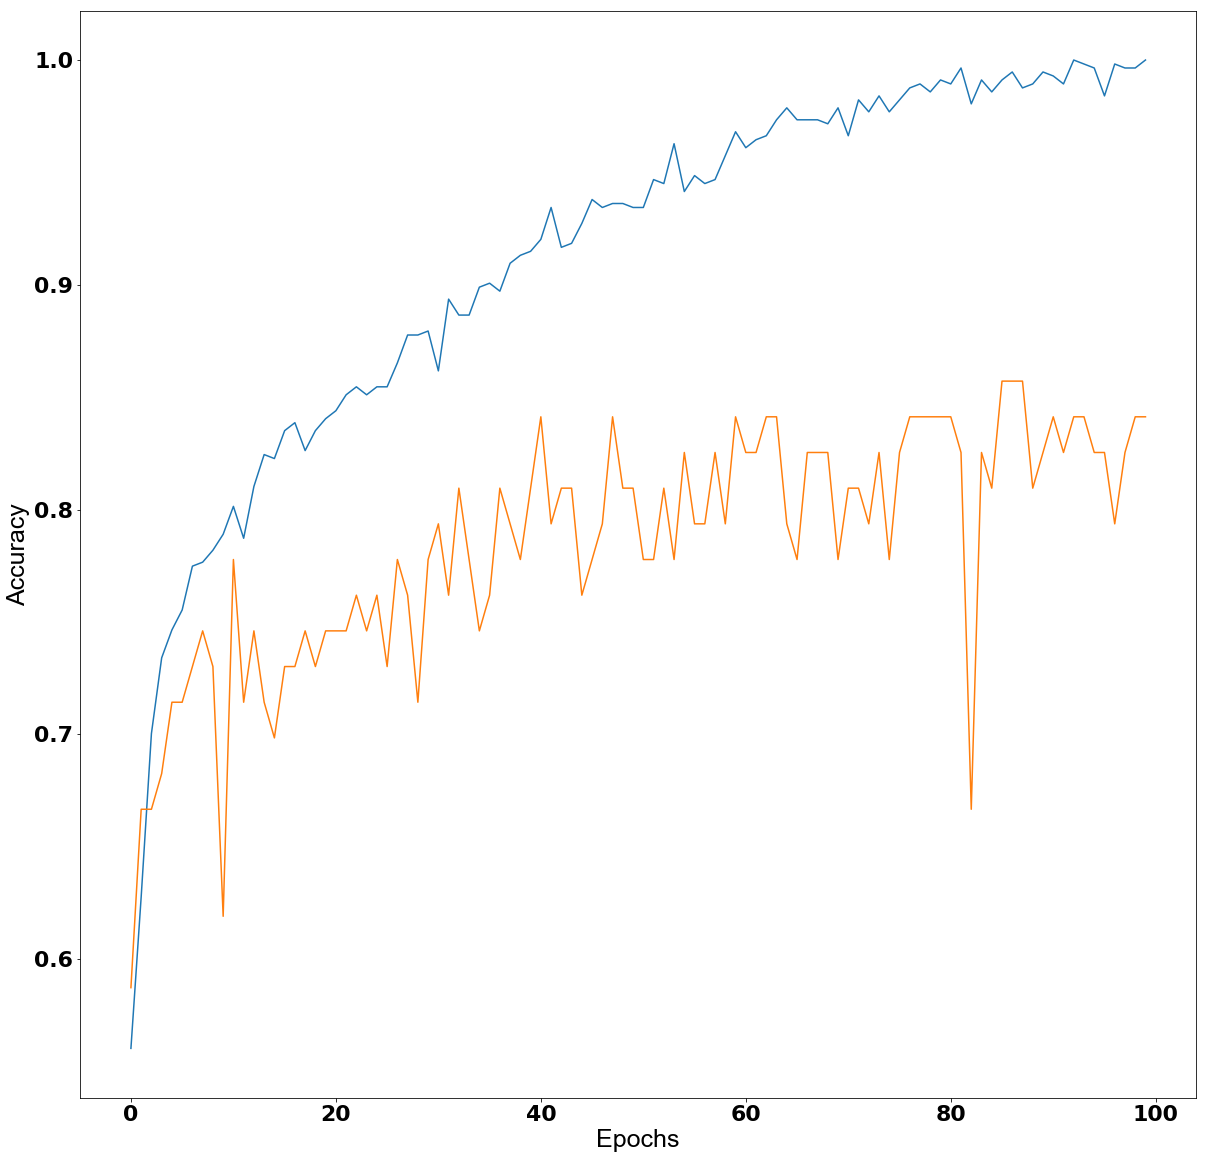

In [15]:
#plot the accuracy of the training set  and the validation set of the model
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
axis_font = {'fontname':'Arial', 'size':'25'}

plt.figure(figsize=[20,20])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy', **axis_font)
plt.xlabel('Epochs', **axis_font)

plt.show()


# Confusion Matrix

In [16]:
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float")/ cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix, without normalisation")
        
    print (cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
        horizontalalignment = "center",
        color="white" if cm[i,j] > thresh else "black" )
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    



Confusion matrix, without normalisation
[[120  10]
 [ 42  97]]


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


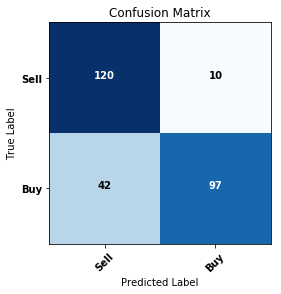

In [17]:
cm = confusion_matrix(y_test, predictions)
cm_labels = ['Sell', 'Buy']
plot_confusion_matrix(cm, cm_labels, title="Confusion Matrix")

Confusion matrix, without normalisation
[[115  15]
 [ 27 112]]


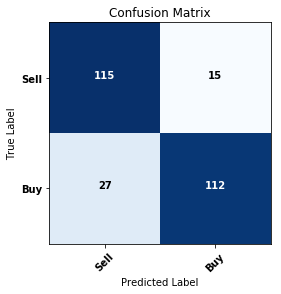

In [18]:
cm2 = confusion_matrix(y_test, over_fit_predictions)
cm_labels = ['Sell', 'Buy']
plot_confusion_matrix(cm2, cm_labels, title="Confusion Matrix")